In [1]:
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

In [4]:
from keras.preprocessing.text import Tokenizer

C:\New folder\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [5]:
from keras.preprocessing.sequence import pad_sequences

In [6]:
from keras.models import Sequential

In [7]:
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM

In [8]:
from keras import utils

In [9]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [10]:
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

In [11]:
import gensim

C:\New folder\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [12]:
import re

In [13]:
import numpy as np

In [14]:
import os

In [15]:
from collections import Counter

In [16]:
import logging

import `

In [17]:
import pickle

In [18]:
import itertools

In [19]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [20]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Virendra\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [21]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

In [22]:
df = pd.read_csv("training.1600000.processed.noemoticon.csv", encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

In [23]:
print("Dataset size:", len(df))

Dataset size: 1600000


In [24]:
df.head(5)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [25]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [26]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

Wall time: 1.45 s


Text(0.5,1,'Dataset labels distribuition')

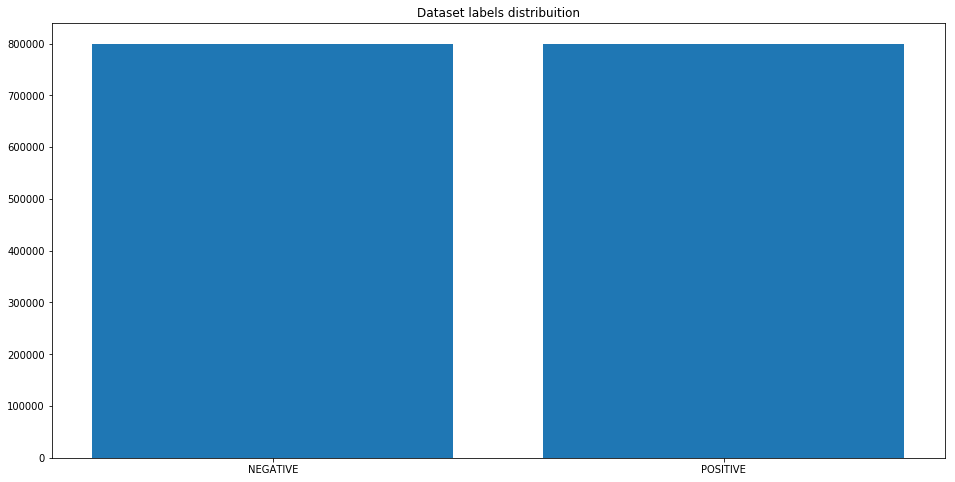

In [27]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [28]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [29]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [30]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

Wall time: 1min 42s


In [31]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1280000
TEST size: 320000


In [32]:
%%time
documents = [_text.split() for _text in df_train.text] 

Wall time: 4.03 s


In [33]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [34]:
w2v_model.build_vocab(documents)

2019-08-12 11:18:51,793 : INFO : collecting all words and their counts
2019-08-12 11:18:51,795 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-08-12 11:18:51,822 : INFO : PROGRESS: at sentence #10000, processed 72565 words, keeping 14005 word types
2019-08-12 11:18:51,867 : INFO : PROGRESS: at sentence #20000, processed 144393 words, keeping 21587 word types
2019-08-12 11:18:51,936 : INFO : PROGRESS: at sentence #30000, processed 215826 words, keeping 27541 word types
2019-08-12 11:18:51,994 : INFO : PROGRESS: at sentence #40000, processed 288271 words, keeping 32764 word types
2019-08-12 11:18:52,040 : INFO : PROGRESS: at sentence #50000, processed 359772 words, keeping 37587 word types
2019-08-12 11:18:52,110 : INFO : PROGRESS: at sentence #60000, processed 431431 words, keeping 42198 word types
2019-08-12 11:18:52,158 : INFO : PROGRESS: at sentence #70000, processed 503103 words, keeping 46458 word types
2019-08-12 11:18:52,214 : INFO : PROGRESS: at s

2019-08-12 11:18:55,747 : INFO : PROGRESS: at sentence #720000, processed 5193881 words, keeping 200325 word types
2019-08-12 11:18:55,808 : INFO : PROGRESS: at sentence #730000, processed 5265467 words, keeping 202133 word types
2019-08-12 11:18:55,873 : INFO : PROGRESS: at sentence #740000, processed 5337518 words, keeping 203818 word types
2019-08-12 11:18:55,938 : INFO : PROGRESS: at sentence #750000, processed 5409321 words, keeping 205535 word types
2019-08-12 11:18:56,005 : INFO : PROGRESS: at sentence #760000, processed 5481512 words, keeping 207282 word types
2019-08-12 11:18:56,071 : INFO : PROGRESS: at sentence #770000, processed 5554093 words, keeping 209076 word types
2019-08-12 11:18:56,133 : INFO : PROGRESS: at sentence #780000, processed 5625382 words, keeping 210805 word types
2019-08-12 11:18:56,231 : INFO : PROGRESS: at sentence #790000, processed 5698066 words, keeping 212618 word types
2019-08-12 11:18:56,277 : INFO : PROGRESS: at sentence #800000, processed 577088

In [36]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 30369


In [37]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2019-08-12 11:19:34,407 : INFO : training model with 8 workers on 30369 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
2019-08-12 11:19:35,543 : INFO : EPOCH 1 - PROGRESS: at 4.34% examples, 340038 words/s, in_qsize 15, out_qsize 0
2019-08-12 11:19:36,618 : INFO : EPOCH 1 - PROGRESS: at 8.58% examples, 332041 words/s, in_qsize 16, out_qsize 2
2019-08-12 11:19:37,651 : INFO : EPOCH 1 - PROGRESS: at 13.90% examples, 360876 words/s, in_qsize 15, out_qsize 0
2019-08-12 11:19:38,680 : INFO : EPOCH 1 - PROGRESS: at 18.76% examples, 368173 words/s, in_qsize 15, out_qsize 0
2019-08-12 11:19:39,689 : INFO : EPOCH 1 - PROGRESS: at 23.52% examples, 372285 words/s, in_qsize 15, out_qsize 0
2019-08-12 11:19:40,742 : INFO : EPOCH 1 - PROGRESS: at 28.07% examples, 369376 words/s, in_qsize 16, out_qsize 0
2019-08-12 11:19:41,804 : INFO : EPOCH 1 - PROGRESS: at 33.05% examples, 371781 words/s, in_qsize 14, out_qsize 1
2019-08-12 11:19:42,875 : INFO : EPOCH 1 - PROGRESS: a

2019-08-12 11:20:34,667 : INFO : EPOCH 3 - PROGRESS: at 84.47% examples, 375103 words/s, in_qsize 13, out_qsize 2
2019-08-12 11:20:35,689 : INFO : EPOCH 3 - PROGRESS: at 89.34% examples, 376185 words/s, in_qsize 16, out_qsize 1
2019-08-12 11:20:36,707 : INFO : EPOCH 3 - PROGRESS: at 94.36% examples, 377493 words/s, in_qsize 15, out_qsize 0
2019-08-12 11:20:37,714 : INFO : EPOCH 3 - PROGRESS: at 98.69% examples, 376157 words/s, in_qsize 13, out_qsize 0
2019-08-12 11:20:37,785 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-08-12 11:20:37,793 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-08-12 11:20:37,804 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-08-12 11:20:37,812 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-08-12 11:20:37,834 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-08-12 11:20:37,842 : INFO : worker thread finished; awaiting finish of 2 more thread

2019-08-12 11:22:10,967 : INFO : EPOCH 10 - PROGRESS: at 75.78% examples, 677322 words/s, in_qsize 16, out_qsize 0
2019-08-12 11:22:12,006 : INFO : EPOCH 10 - PROGRESS: at 84.05% examples, 675146 words/s, in_qsize 15, out_qsize 0
2019-08-12 11:22:13,040 : INFO : EPOCH 10 - PROGRESS: at 90.87% examples, 662925 words/s, in_qsize 15, out_qsize 0
2019-08-12 11:22:14,045 : INFO : EPOCH 10 - PROGRESS: at 97.61% examples, 653648 words/s, in_qsize 15, out_qsize 0
2019-08-12 11:22:14,212 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-08-12 11:22:14,238 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-08-12 11:22:14,242 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-08-12 11:22:14,244 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-08-12 11:22:14,270 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-08-12 11:22:14,277 : INFO : worker thread finished; awaiting finish of 2 more th

2019-08-12 11:23:02,092 : INFO : EPOCH 13 - PROGRESS: at 93.26% examples, 501765 words/s, in_qsize 15, out_qsize 0
2019-08-12 11:23:02,901 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-08-12 11:23:02,911 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-08-12 11:23:02,914 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-08-12 11:23:02,920 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-08-12 11:23:02,934 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-08-12 11:23:02,943 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-08-12 11:23:02,944 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-08-12 11:23:02,952 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-08-12 11:23:02,953 : INFO : EPOCH - 13 : training on 9227204 raw words (8223230 effective words) took 16.1s, 509697 effective words/s
2019-08-12 11:23:0

2019-08-12 11:23:48,094 : INFO : EPOCH 17 - PROGRESS: at 48.84% examples, 652928 words/s, in_qsize 15, out_qsize 0
2019-08-12 11:23:49,109 : INFO : EPOCH 17 - PROGRESS: at 56.08% examples, 643850 words/s, in_qsize 16, out_qsize 0
2019-08-12 11:23:50,141 : INFO : EPOCH 17 - PROGRESS: at 64.73% examples, 650130 words/s, in_qsize 13, out_qsize 2
2019-08-12 11:23:51,171 : INFO : EPOCH 17 - PROGRESS: at 73.30% examples, 654013 words/s, in_qsize 16, out_qsize 2
2019-08-12 11:23:52,166 : INFO : EPOCH 17 - PROGRESS: at 80.57% examples, 648334 words/s, in_qsize 15, out_qsize 0
2019-08-12 11:23:53,166 : INFO : EPOCH 17 - PROGRESS: at 88.91% examples, 651461 words/s, in_qsize 15, out_qsize 0
2019-08-12 11:23:54,208 : INFO : EPOCH 17 - PROGRESS: at 97.50% examples, 653500 words/s, in_qsize 15, out_qsize 0
2019-08-12 11:23:54,396 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-08-12 11:23:54,401 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-08-12 11

2019-08-12 11:24:34,794 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-08-12 11:24:34,810 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-08-12 11:24:34,810 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-08-12 11:24:34,810 : INFO : EPOCH - 20 : training on 9227204 raw words (8222886 effective words) took 13.5s, 608276 effective words/s
2019-08-12 11:24:35,841 : INFO : EPOCH 21 - PROGRESS: at 6.73% examples, 541001 words/s, in_qsize 15, out_qsize 0
2019-08-12 11:24:36,869 : INFO : EPOCH 21 - PROGRESS: at 14.75% examples, 591351 words/s, in_qsize 15, out_qsize 0
2019-08-12 11:24:37,903 : INFO : EPOCH 21 - PROGRESS: at 22.87% examples, 609972 words/s, in_qsize 12, out_qsize 3
2019-08-12 11:24:38,974 : INFO : EPOCH 21 - PROGRESS: at 31.11% examples, 616262 words/s, in_qsize 14, out_qsize 1
2019-08-12 11:24:39,967 : INFO : EPOCH 21 - PROGRESS: at 38.89% examples, 620684 words/s, in_qsize 12, out_qsize 3
2019-08-12 11:

2019-08-12 11:25:24,284 : INFO : EPOCH 24 - PROGRESS: at 87.29% examples, 633313 words/s, in_qsize 15, out_qsize 0
2019-08-12 11:25:25,292 : INFO : EPOCH 24 - PROGRESS: at 96.09% examples, 639655 words/s, in_qsize 14, out_qsize 1
2019-08-12 11:25:25,681 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-08-12 11:25:25,700 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-08-12 11:25:25,708 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-08-12 11:25:25,716 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-08-12 11:25:25,716 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-08-12 11:25:25,732 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-08-12 11:25:25,732 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-08-12 11:25:25,748 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-08-12 11:25:25,748 : INFO : EPOCH - 2

2019-08-12 11:26:08,595 : INFO : EPOCH 28 - PROGRESS: at 39.22% examples, 610778 words/s, in_qsize 15, out_qsize 0
2019-08-12 11:26:09,598 : INFO : EPOCH 28 - PROGRESS: at 47.54% examples, 622407 words/s, in_qsize 16, out_qsize 0
2019-08-12 11:26:10,652 : INFO : EPOCH 28 - PROGRESS: at 54.99% examples, 616836 words/s, in_qsize 14, out_qsize 1
2019-08-12 11:26:11,646 : INFO : EPOCH 28 - PROGRESS: at 62.47% examples, 616584 words/s, in_qsize 15, out_qsize 0
2019-08-12 11:26:12,676 : INFO : EPOCH 28 - PROGRESS: at 68.42% examples, 601458 words/s, in_qsize 10, out_qsize 6
2019-08-12 11:26:13,685 : INFO : EPOCH 28 - PROGRESS: at 74.60% examples, 591877 words/s, in_qsize 13, out_qsize 3
2019-08-12 11:26:14,763 : INFO : EPOCH 28 - PROGRESS: at 80.90% examples, 581246 words/s, in_qsize 16, out_qsize 0
2019-08-12 11:26:15,780 : INFO : EPOCH 28 - PROGRESS: at 86.42% examples, 569738 words/s, in_qsize 15, out_qsize 0
2019-08-12 11:26:16,788 : INFO : EPOCH 28 - PROGRESS: at 94.36% examples, 575423

2019-08-12 11:26:57,730 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-08-12 11:26:57,733 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-08-12 11:26:57,738 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-08-12 11:26:57,748 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-08-12 11:26:57,763 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-08-12 11:26:57,763 : INFO : EPOCH - 31 : training on 9227204 raw words (8221983 effective words) took 12.7s, 646317 effective words/s
2019-08-12 11:26:58,779 : INFO : EPOCH 32 - PROGRESS: at 7.71% examples, 626195 words/s, in_qsize 14, out_qsize 1
2019-08-12 11:26:59,786 : INFO : EPOCH 32 - PROGRESS: at 16.05% examples, 652836 words/s, in_qsize 14, out_qsize 1
2019-08-12 11:27:00,789 : INFO : EPOCH 32 - PROGRESS: at 23.63% examples, 642065 words/s, in_qsize 11, out_qsize 4
2019-08-12 11:27:01,833 : INFO : EPOCH 32 - PROGRESS: at 32.19

Wall time: 7min 35s


(263119073, 295270528)

In [40]:
w2v_model.most_similar("love")

C:\New folder\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('luv', 0.5672323703765869),
 ('loves', 0.5513563752174377),
 ('loved', 0.546675443649292),
 ('amazing', 0.5133724808692932),
 ('adore', 0.5112200379371643),
 ('looove', 0.4902918040752411),
 ('awesome', 0.46070125699043274),
 ('loooove', 0.44767796993255615),
 ('loveee', 0.4462668001651764),
 ('miss', 0.4351269602775574)]

In [41]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 290419
Wall time: 19.7 s


In [42]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

Wall time: 28.8 s


In [43]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [44]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1280000, 1)
y_test (320000, 1)


In [45]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1280000, 300)
y_train (1280000, 1)

x_test (320000, 300)
y_test (320000, 1)


In [46]:
y_train[:10]

array([[1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]], dtype=int64)

In [47]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(290419, 300)


In [48]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

In [49]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Instructions for updating:
Colocations handled automatically by placer.


2019-08-12 11:58:46,396 : WARNING : From C:\New folder\lib\site-packages\tensorflow\python\framework\op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


2019-08-12 11:59:12,879 : WARNING : From C:\New folder\lib\site-packages\keras\backend\tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          87125700  
_________________________________________________________________
dropout_1 (Dropout)          (None, 300, 300)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 87,286,201
Trainable params: 160,501
Non-trainable params: 87,125,700
_________________________________________________________________


In [50]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [51]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

In [ ]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Instructions for updating:
Use tf.cast instead.


2019-08-12 11:59:33,455 : WARNING : From C:\New folder\lib\site-packages\tensorflow\python\ops\math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


Train on 1152000 samples, validate on 128000 samples
Epoch 1/8
  43008/1152000 [>.............................] - ETA: 3:38:03 - loss: 0.5949 - acc: 0.6745

In [ ]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [ ]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [ ]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at} 

In [ ]:
predict("I love the music")

In [ ]:
predict("I hate the rain")

In [ ]:
predict("i don't know what i'm doing")

In [ ]:
predict("awesome, I miss my flight")

In [ ]:
predict("pleasure, to meet you")